In [2]:
import sys
sys.path.append('../../')
sys.path.append('../../utils/')

import scipy
import json
import deepbayesHF
import deepbayesHF.optimizers as optimizers
from deepbayesHF import PosteriorModel
from deepbayesHF.analyzers import FGSM
from deepbayesHF.analyzers import eps_LRP
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import cv2
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from load_data import load_data, load_embedding_function

from embedding import Embedding
from scipy.spatial import ConvexHull
from operator import itemgetter

sys.path.append('../../abduction_algorithms')
#from abduction_algorithms import knn_smallest_explanation_linf
#from abduction_algorithms_HS_cost import knn_smallest_explanation_linf_with_cost, Entails
from abduction_algorithms_neu import logger, smallest_explanation
from entails_neu import entails

import itertools

sys.path.append('./../../../Marabou/')
from maraboupy import Marabou
from maraboupy import MarabouUtils, MarabouCore
from hitman_cost import HitmanCost

import json
import numpy as np

import adversarial_attacks as adv

import ast
from itertools import chain, combinations
import pickle
import math

import subprocess

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def print_exp(exp,text,maxlen,num_exps=1):
 
    xs = []
    ys = []
    for i in range(maxlen):
        txt = text[i] if i < len(text) else '<PAD>'
        if not txt == '<PAD>':
            c = text.count(txt)
        else:
            c = maxlen - len(text)
        total = int(exp.count(txt)/c)/num_exps
        xs.append(txt)
        ys.append(total)
        
    objects = xs[::-1]
    y_pos = np.arange(len(objects))
    performance = ys[::-1]

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Weight')
    plt.title('Word')

    plt.show()
    
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
def get_all_of_cost(cost,word_cost_func,padded_input):
    # first get all combinations of input
    equal_cost = []
    equal_ids = []
    pwset = list(powerset((list(zip(range(len(padded_input)),padded_input)))))
    for pw in pwset:
        words = [p[1] for p in pw]
        ids = [p[0] for p in pw]
        if sum([word_cost_func[w] for w in words]) == cost:
            equal_cost.append(words)
            equal_ids.append(ids)
            
    return equal_cost,equal_ids

#a, b = get_all_of_cost(2,word_cost_func,['an','absurdist','comedy','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>'])
    

# Load Data

In [4]:
maxlen = 10
emb_dims = 5
ksize = None
X_train, y_train, X_test, y_test, text_train, text_test = load_data('SST',maxlen,emb_dims,'../../training_data/','../../embeddings/',True)

In [5]:
X_train = (X_train+1)/2
X_train[X_train==0.5] = 0

X_test = (X_test+1)/2
X_test[X_test==0.5] = 0

In [6]:
print(X_train[0])
print(text_train[0])

[0.41338056 0.5941256  0.44433823 0.58278245 0.5368206  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
['brilliant']


## Train model (optional)

In [27]:
model_name = f'SST_{maxlen}x{emb_dims}d_16_8_neurify'

opt = optimizers.VariationalOnlineGuassNewton()
likelihood = tf.keras.losses.SparseCategoricalCrossentropy()
model = Sequential()
model.add(Dense(16,activation='relu',input_shape=X_train[0].shape))
model.add(Dense(8,activation='relu'))
model.add(Dense(2,activation='softmax'))

bayes_model = opt.compile(model,loss_fn=likelihood,
                          epochs=25, learning_rate=0.25,
                          inflate_prior=2.0, log_file='tmp/log.txt')
bayes_model.train(X_train,y_train,X_test,y_test)
bayes_model.save(model_name)

This optimizer does not have a default compilation method. Please make sure to call the correct .compile method before use.
deepbayes: Using implicit prior
(50, 16) 0.2
(16, 8) 0.3535533905932738
(8, 2) 0.5
deepbayes: Using implicit prior
(50, 16) 0.2
(16, 8) 0.3535533905932738
(8, 2) 0.5


  1%|          | 11/1832 [00:00<00:17, 102.16it/s]

Epoch 1, loss: 0.688, acc: 0.550, val_loss: 0.697, val_acc: 0.510


  1%|          | 11/1832 [00:00<00:16, 107.40it/s]

Epoch 2, loss: 0.674, acc: 0.606, val_loss: 0.688, val_acc: 0.541


  1%|          | 11/1832 [00:00<00:17, 107.09it/s]

Epoch 3, loss: 0.552, acc: 0.709, val_loss: 0.478, val_acc: 0.756


  1%|          | 12/1832 [00:00<00:15, 116.69it/s]

Epoch 4, loss: 0.351, acc: 0.848, val_loss: 0.738, val_acc: 0.716


  1%|          | 12/1832 [00:00<00:16, 111.89it/s]

Epoch 5, loss: 0.355, acc: 0.851, val_loss: 0.914, val_acc: 0.688


  1%|          | 11/1832 [00:00<00:16, 109.74it/s]

Epoch 6, loss: 0.410, acc: 0.817, val_loss: 0.637, val_acc: 0.738


  1%|          | 12/1832 [00:00<00:15, 114.99it/s]

Epoch 7, loss: 0.379, acc: 0.838, val_loss: 0.482, val_acc: 0.798


  1%|          | 12/1832 [00:00<00:15, 114.53it/s]

Epoch 8, loss: 0.317, acc: 0.872, val_loss: 0.494, val_acc: 0.809


  1%|          | 10/1832 [00:00<00:18, 97.87it/s]

Epoch 9, loss: 0.299, acc: 0.878, val_loss: 0.514, val_acc: 0.790


  1%|          | 12/1832 [00:00<00:15, 117.39it/s]

Epoch 10, loss: 0.298, acc: 0.878, val_loss: 0.515, val_acc: 0.786


  1%|          | 12/1832 [00:00<00:15, 114.30it/s]

Epoch 11, loss: 0.300, acc: 0.876, val_loss: 0.501, val_acc: 0.795


  1%|          | 12/1832 [00:00<00:16, 113.06it/s]

Epoch 12, loss: 0.298, acc: 0.877, val_loss: 0.472, val_acc: 0.807


  1%|          | 12/1832 [00:00<00:15, 113.97it/s]

Epoch 13, loss: 0.293, acc: 0.879, val_loss: 0.467, val_acc: 0.816


  1%|          | 12/1832 [00:00<00:15, 113.93it/s]

Epoch 14, loss: 0.292, acc: 0.879, val_loss: 0.472, val_acc: 0.812


  1%|          | 12/1832 [00:00<00:16, 112.77it/s]

Epoch 15, loss: 0.287, acc: 0.882, val_loss: 0.466, val_acc: 0.811


  1%|          | 12/1832 [00:00<00:15, 116.73it/s]

Epoch 16, loss: 0.286, acc: 0.882, val_loss: 0.465, val_acc: 0.813


  1%|          | 12/1832 [00:00<00:16, 112.94it/s]

Epoch 17, loss: 0.284, acc: 0.883, val_loss: 0.462, val_acc: 0.816


  1%|          | 12/1832 [00:00<00:16, 113.35it/s]

Epoch 18, loss: 0.283, acc: 0.884, val_loss: 0.466, val_acc: 0.814


  1%|          | 12/1832 [00:00<00:15, 115.95it/s]

Epoch 19, loss: 0.282, acc: 0.884, val_loss: 0.463, val_acc: 0.816


  1%|          | 12/1832 [00:00<00:16, 112.65it/s]

Epoch 20, loss: 0.282, acc: 0.884, val_loss: 0.457, val_acc: 0.813


  1%|          | 12/1832 [00:00<00:15, 116.63it/s]

Epoch 21, loss: 0.281, acc: 0.884, val_loss: 0.462, val_acc: 0.815


  1%|          | 11/1832 [00:00<00:17, 105.91it/s]

Epoch 22, loss: 0.280, acc: 0.885, val_loss: 0.458, val_acc: 0.814


  1%|          | 12/1832 [00:00<00:16, 112.82it/s]

Epoch 23, loss: 0.280, acc: 0.884, val_loss: 0.456, val_acc: 0.814


  1%|          | 12/1832 [00:00<00:15, 117.80it/s]

Epoch 24, loss: 0.279, acc: 0.885, val_loss: 0.456, val_acc: 0.812


  1%|          | 12/1832 [00:00<00:15, 116.88it/s]

Epoch 25, loss: 0.279, acc: 0.884, val_loss: 0.453, val_acc: 0.814


100%|██████████| 1832/1832 [00:14<00:00, 125.77it/s]


Epoch 26, loss: 0.279, acc: 0.884, val_loss: 0.458, val_acc: 0.812
('batch_size', 64)
('learning_rate', 0.25)
('decay', 0.0)
('epochs', 26)
('inflate_prior', 2.0)
('input_noise', 0.0)
('robust_train', 0)
('epsilon', 0.1)
('robust_lambda', 0.5)
('loss_monte_carlo', 2)
('input_upper', inf)
('input_lower', -inf)
('beta_1', 0.999)
('beta_2', 0.9999)
('lam', 1.0)
('N', 117219)
('max_eps', 0.1)
('max_robust_lambda', 0.5)


# Load Model

In [7]:
model_name = f'SST_{maxlen}x{emb_dims}d_16_8_neurify'
bayes_model = PosteriorModel(model_name)
y_pred = bayes_model.predict(X_test,n=50)
check_accuracy = tf.keras.metrics.Accuracy(name="train_acc")
check_accuracy(y_test,np.argmax(y_pred,axis=1))
print()
print('Loaded model accuracy:',f'{check_accuracy.result().numpy()*100:.2f}%')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 970
Trainable params: 970
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None

Loaded model accuracy: 81.26%


# Random positive example runs

In [13]:
N = 50

while True:
    # pick a random input
    n = np.random.choice(list(range(len(X_train))))
    if '' in text_train[n] or len(text_train[n])<8:
        continue
    X = X_train[n].reshape(1,*X_train[n].shape)
    y_hat = np.argmax(bayes_model.predict(X,n=N))
    if y_hat == y_train[n] and y_hat == 1:
        break

print(n)    
y_class = 'Positive.' if y_hat == 1 else 'Negative.'
y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
print(text_train[n])
print('Prediction:',y_class,'Ground truth:',y_true_text)
input_shape = X.flatten().shape

83298
['of', 'heartbreaking', 'honesty', 'to', 'keep', 'one', 'glued', 'to', 'the', 'screen']
Prediction: Positive. Ground truth: Positive.


In [26]:
print(n)

16991


In [15]:
ns = [16991,116122,54669,49104,101139,31587,15353,5484,104829,83298]
epss = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]

### explanation calculation (takes about 2 mins)

In [16]:
all_exps = []

for idx in range(len(ns)):
#for idx in range(1):
    n = ns[idx]
    #n = 83298
    epsilon = epss[idx]
    #epsilon = 0.02
    #knn = 10
    X = X_train[n].reshape(1,*X_train[n].shape)
    N = 50
    y_hat = np.argmax(bayes_model.predict(X,n=N))
    y_class = 'Positive.' if y_hat == 1 else 'Negative.'
    y_true_text = 'Positive.' if y_train[n] == 1 else 'Negative.'
    input_shape = X.flatten().shape

    input_len = maxlen
    window_size = emb_dims

    embedding, word2index, index2word, index2embedding = load_embedding_function('SST',maxlen,emb_dims,'../../embeddings/')
    shape = (1,maxlen*emb_dims) if ksize == None else (1,ksize,ksize,emb_dims)
    new_i2e = (index2embedding+1)/2
    new_i2e[new_i2e==0.5] = 0
    index2embedding = new_i2e

    text_list = text_train[n]

    input_ = text_list[:maxlen] + ['<PAD>']*(maxlen-len(text_list))
    padded_input = input_
    X = X_train[n].reshape(*shape)


    bayes_model = PosteriorModel(model_name)

    SAMPLES = 20
    c = 0
    excl_list = ['<PAD>']
    word_cost_func = dict()
    for word in padded_input:
        if not word in word_cost_func.keys():
            # if its a pad or not in the embedding, give it a high cost
            #if word == '<PAD>' or word2index[word] <= 2 or word == 'arliss' or word == 'howard':
            if word in excl_list:
                word_cost_func[word] = 100
            else:
                word_cost_func[word] = 1

    
    
    explanations = dict()
    explanations['fw+'] = []
    explanations['fw-'] = []
    while c < SAMPLES:
        tmp_weights = bayes_model.sample()
        bayes_model.set_weights(tmp_weights)
        model = bayes_model.model
        tmp_h5 = 'neurify_sst_fc_tmp.h5'
        model.save(tmp_h5)
        subprocess.run(['python3','convert_to_nnet.py',tmp_h5])
        c += 1

        input_shape = X.shape
        prediction = model.predict(X)
        input_ = X.flatten().tolist()
        y_hat = np.argmax(prediction)
        act_y = y_train[n]
        c_hat = np.max(prediction)
        HS_maxlen = 1e7
        verbose = False
        
        if act_y == y_hat:
            print('Model in fw+')
            fw = 'fw+'
        else:
            print('Model in fw-')
            fw = 'fw-' 
        print("Classifiation for the input is {} (confidence {})".format(y_hat, c_hat))

        tmp_network_nnet = tmp_h5[:-2]+'nnet'

        output_constraints = [y_hat,(1 if y_hat==0 else 0),1e-3]

        h, exec_time, _ = smallest_explanation(bayes_model.model,tmp_network_nnet,X,epsilon,y_hat,output_constraints,5,HS_maxlen=10000000,verbose=False)
        print("Minimum Size Explanation found {} (size {})".format(h, len(h)/window_size))
        print("Complementary set of Minimum Size Explanation is {}".format([i for i in range(maxlen*emb_dims) if i not in h]))
        print("Execution Time: {}".format(exec_time))

        word_ids = [int(i/emb_dims) for idx,i in enumerate(h) if idx % emb_dims == 0 ]
        sorted(word_ids)
        words_out = [w for idx,w in enumerate(padded_input) if idx in word_ids]
        print(words_out)
        
        # words out is our first ORE
        # now get all ORES of that cost

        #first get all combinations of that same cost
        cost = sum([word_cost_func[w] for w in words_out])
        print('COST:',cost)
        combs, combs_ids = get_all_of_cost(cost,word_cost_func,padded_input)
        input_bounds = [[input_[i]-epsilon if input_[i]-epsilon >= 0 else 0, input_[i]+epsilon if input_[i]+epsilon <= 1 else 1] for i in range(len(input_))]
        u_bounds = [float(e[1]) for e in input_bounds]
        l_bounds = [float(e[0]) for e in input_bounds]
        #print(u_bounds)
        #print(l_bounds)
        #print(len(u_bounds))
        #print(len(l_bounds))

        # then check if they are also an ORE (entails)
        ores = []
        for idx,comb in enumerate(combs):
            # convert to indices
            h = []
            for idy, word in enumerate(comb):
                w_id = combs_ids[idx][idy]
                start = w_id*emb_dims
                end = (w_id*emb_dims)+emb_dims
                for wi in range(start,end):
                    h.append(wi)
            res = entails(h, len(h), input_, len(input_), u_bounds, l_bounds, tmp_network_nnet)
            if res == 0:
                ores.append(comb)
        if len(words_out) == maxlen:
            ores = [words_out]
        
        explanations[fw].append(ores)
        print(ores)

    #print(explanations)
    all_exps.append(explanations)
    np.save(f'ORE_bayesian_exps_ALL_UNCERT/exps_idx{n}.npy',explanations)


print(all_exps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 970
Trainable params: 970
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None
Model in fw+
Classifiation for the input is 1 (confidence 0.959867537021637)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 5.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 4

Model in fw+
Classifiation for the input is 1 (confidence 0.9710654616355896)
Minimum Size Explanation found [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.7113492488861084
['i', 'a', 'smartly', 'written']
COST: 4
[['i', 'have', 'always', 'appreciated'], ['i', 'have', 'always', 'a'], ['i', 'have', 'always', 'smartly'], ['i', 'have', 'always', 'written'], ['i', 'have', 'always', 'motion'], ['i', 'have', 'always', 'picture'], ['i', 'have', 'appreciated', 'a'], ['i', 'have', 'appreciated', 'smartly'], ['i', 'have', 'appreciated', 'written'], ['i', 'have', 'appreciated', 'motion'], ['i', 'have', 'appreciated', 'picture'], ['i', 'have', 'a', 'smartly'], ['i', 'have', 'a', 'written'], ['i', 'have', 'a', 'motion'], ['i', 'have', 'a', 'picture'], ['i', 'have', 'smartly', 'wr

Minimum Size Explanation found [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.8927693367004395
['i', 'a', 'smartly', 'written']
COST: 4
[['i', 'have', 'always', 'appreciated'], ['i', 'have', 'always', 'a'], ['i', 'have', 'always', 'smartly'], ['i', 'have', 'always', 'written'], ['i', 'have', 'always', 'motion'], ['i', 'have', 'always', 'picture'], ['i', 'have', 'appreciated', 'a'], ['i', 'have', 'appreciated', 'smartly'], ['i', 'have', 'appreciated', 'written'], ['i', 'have', 'appreciated', 'motion'], ['i', 'have', 'appreciated', 'picture'], ['i', 'have', 'a', 'smartly'], ['i', 'have', 'a', 'written'], ['i', 'have', 'a', 'motion'], ['i', 'have', 'a', 'picture'], ['i', 'have', 'smartly', 'written'], ['i', 'have', 'smartly', 'motion'], ['i', 'have', 'smartly', 'picture

Model in fw+
Classifiation for the input is 1 (confidence 0.9705749154090881)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.3707542419433594
['i', 'have', 'smartly', 'written']
COST: 4
[['i', 'have', 'always', 'appreciated'], ['i', 'have', 'always', 'a'], ['i', 'have', 'always', 'smartly'], ['i', 'have', 'always', 'written'], ['i', 'have', 'always', 'motion'], ['i', 'have', 'always', 'picture'], ['i', 'have', 'appreciated', 'a'], ['i', 'have', 'appreciated', 'smartly'], ['i', 'have', 'appreciated', 'written'], ['i', 'have', 'appreciated', 'motion'], ['i', 'have', 'appreciated', 'picture'], ['i', 'have', 'a', 'smartly'], ['i', 'have', 'a', 'written'], ['i', 'have', 'a', 'motion'], ['i', 'have', 'a', 'picture'], ['i', 'have', 'smartly', 

Model in fw+
Classifiation for the input is 1 (confidence 0.9428920745849609)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 40, 41, 42, 43, 44] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 13.362307071685791
['i', 'have', 'always', 'appreciated', 'a', 'picture']
COST: 6
[['i', 'have', 'always', 'appreciated', 'a', 'smartly'], ['i', 'have', 'always', 'appreciated', 'a', 'written'], ['i', 'have', 'always', 'appreciated', 'a', 'motion'], ['i', 'have', 'always', 'appreciated', 'a', 'picture'], ['i', 'have', 'always', 'appreciated', 'smartly', 'written'], ['i', 'have', 'always', 'appreciated', 'smartly', 'motion'], ['i', 'have', 'always', 'appreciated', 'smartly', 'picture'], ['i', 'have', 'always', 'appreciated', 'written', 'motion'], ['i', 'have', 'always', 'appreciated', 'written', 'picture'], ['i', 'ha

Model in fw+
Classifiation for the input is 1 (confidence 0.9796403050422668)
Minimum Size Explanation found [0, 1, 2, 3, 4, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44] (size 3.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 0.5591576099395752
['i', 'written', 'picture']
COST: 3
[['i', 'have', 'always'], ['i', 'have', 'appreciated'], ['i', 'have', 'a'], ['i', 'have', 'smartly'], ['i', 'have', 'written'], ['i', 'have', 'motion'], ['i', 'have', 'picture'], ['i', 'always', 'appreciated'], ['i', 'always', 'a'], ['i', 'always', 'smartly'], ['i', 'always', 'written'], ['i', 'always', 'motion'], ['i', 'always', 'picture'], ['i', 'appreciated', 'a'], ['i', 'appreciated', 'smartly'], ['i', 'appreciated', 'written'], ['i', 'appreciated', 'motion'], ['i', 'appreciated', 'picture'], ['i', 'a', 'smartly'], ['i', 'a', 'written'], ['i', 'a', 'motion']

Model in fw+
Classifiation for the input is 1 (confidence 0.8813542127609253)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 7.0)
Complementary set of Minimum Size Explanation is [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 20.42313861846924
['worthy', 'of', 'a', 'place', 'alongside', 'the', 'other']
COST: 7
[['worthy', 'of', 'a', 'place', 'alongside', 'the', 'other'], ['worthy', 'of', 'a', 'place', 'alongside', 'the', 'hannibal'], ['worthy', 'of', 'a', 'place', 'alongside', 'the', 'movies'], ['worthy', 'of', 'a', 'place', 'alongside', 'other', 'movies'], ['worthy', 'of', 'a', 'place', 'the', 'other', 'movies'], ['worthy', 'of', 'a', 'alongside', 'the', 'other', 'movies'], ['worthy', 'of', 'place', 'alongside', 'the', 'other', 'movies']]
Model in fw+
Classifiation for the input is 1 (confidence 0.734735906124115)
Minimum Size Explanati

Model in fw+
Classifiation for the input is 1 (confidence 0.9382970929145813)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 40, 41, 42, 43, 44] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 13.253782272338867
['worthy', 'of', 'a', 'place', 'alongside', 'movies']
COST: 6
[['worthy', 'of', 'a', 'place', 'alongside', 'the'], ['worthy', 'of', 'a', 'place', 'alongside', 'other'], ['worthy', 'of', 'a', 'place', 'alongside', 'hannibal'], ['worthy', 'of', 'a', 'place', 'alongside', 'movies'], ['worthy', 'of', 'a', 'place', 'the', 'other'], ['worthy', 'of', 'a', 'place', 'the', 'hannibal'], ['worthy', 'of', 'a', 'place', 'the', 'movies'], ['worthy', 'of', 'a', 'place', 'other', 'hannibal'], ['worthy', 'of', 'a', 'place', 'other', 'movies'], ['worthy', 'of', 'a', 'place', 'hannibal', 'movies'], ['worthy', 'of', 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 970
Trainable params: 970
Non-trainable params: 0
_________________________________________________________________
deepbayes: detected the above model 
 None
Model in fw+
Classifiation for the input is 1 (confidence 0.9854176044464111)
Minimum Size Explanation found [0, 1, 2, 3, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 3.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 

Model in fw+
Classifiation for the input is 1 (confidence 0.9799970388412476)
Minimum Size Explanation found [0, 1, 2, 3, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 3.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Execution Time: 0.5556163787841797
['epic', 'well', 'as']
COST: 3
[['epic', 'quality', 'often'], ['epic', 'quality', 'associated'], ['epic', 'quality', 'with'], ['epic', 'quality', 'stevensons'], ['epic', 'quality', 'tale'], ['epic', 'quality', 'as'], ['epic', 'quality', 'well'], ['epic', 'quality', 'as'], ['epic', 'often', 'associated'], ['epic', 'often', 'with'], ['epic', 'often', 'stevensons'], ['epic', 'often', 'tale'], ['epic', 'often', 'as'], ['epic', 'often', 'well'], ['epic', 'often', 'as'], ['epic', 'associated', 'with'], ['epic', 'associated', 'stevensons'], ['epic', 'associated', 'tale'], ['epic', 'associated', 'as'], ['

Model in fw+
Classifiation for the input is 1 (confidence 0.9729403257369995)
Minimum Size Explanation found [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 46, 47, 48, 49] (size 4.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Execution Time: 1.7870352268218994
['quality', 'often', 'associated', 'as']
COST: 4
[['epic', 'quality', 'often', 'associated'], ['epic', 'quality', 'often', 'with'], ['epic', 'quality', 'often', 'tale'], ['epic', 'quality', 'often', 'as'], ['epic', 'quality', 'often', 'well'], ['epic', 'quality', 'often', 'as'], ['epic', 'quality', 'associated', 'with'], ['epic', 'quality', 'associated', 'tale'], ['epic', 'quality', 'associated', 'as'], ['epic', 'quality', 'associated', 'well'], ['epic', 'quality', 'associated', 'as'], ['epic', 'quality', 'with', 'tale'], ['epic', 'quality', 'with', 'well'], ['epic', 'quality', 'with', 'as'], ['ep

Model in fw+
Classifiation for the input is 1 (confidence 0.9813442230224609)
Minimum Size Explanation found [0, 1, 2, 3, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 3.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Execution Time: 0.5521841049194336
['epic', 'well', 'as']
COST: 3
[['epic', 'quality', 'often'], ['epic', 'quality', 'associated'], ['epic', 'quality', 'with'], ['epic', 'quality', 'tale'], ['epic', 'quality', 'as'], ['epic', 'quality', 'well'], ['epic', 'quality', 'as'], ['epic', 'often', 'associated'], ['epic', 'often', 'with'], ['epic', 'often', 'tale'], ['epic', 'often', 'well'], ['epic', 'often', 'as'], ['epic', 'associated', 'with'], ['epic', 'associated', 'tale'], ['epic', 'associated', 'well'], ['epic', 'associated', 'as'], ['epic', 'with', 'tale'], ['epic', 'with', 'well'], ['epic', 'with', 'as'], ['epic', 'tale', 'as'], [

Model in fw+
Classifiation for the input is 1 (confidence 0.9845178723335266)
Minimum Size Explanation found [15, 16, 17, 18, 19, 45, 46, 47, 48, 49] (size 2.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Execution Time: 0.0969381332397461
['associated', 'as']
COST: 2
[['epic', 'quality'], ['epic', 'often'], ['epic', 'associated'], ['epic', 'with'], ['epic', 'stevensons'], ['epic', 'tale'], ['epic', 'as'], ['epic', 'well'], ['epic', 'as'], ['quality', 'often'], ['quality', 'associated'], ['quality', 'with'], ['quality', 'stevensons'], ['quality', 'tale'], ['quality', 'as'], ['quality', 'well'], ['quality', 'as'], ['often', 'associated'], ['often', 'with'], ['often', 'stevensons'], ['often', 'tale'], ['often', 'as'], ['often', 'well'], ['often', 'as'], ['associated', 'with'], ['associated', 'stevensons'], ['associated', 'tale'], ['as

Model in fw+
Classifiation for the input is 1 (confidence 0.9953433275222778)
Minimum Size Explanation found [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.9886295795440674
['connects', 'level', 'that', 'transcends']
COST: 4
[['connects', 'on', 'a', 'visceral'], ['connects', 'on', 'a', 'level'], ['connects', 'on', 'a', 'that'], ['connects', 'on', 'a', 'transcends'], ['connects', 'on', 'a', 'language'], ['connects', 'on', 'visceral', 'level'], ['connects', 'on', 'visceral', 'that'], ['connects', 'on', 'visceral', 'transcends'], ['connects', 'on', 'visceral', 'language'], ['connects', 'on', 'level', 'that'], ['connects', 'on', 'level', 'transcends'], ['connects', 'on', 'level', 'language'], ['connects', 'on', 'that', 'transcends'], ['connects', 'on', 'that', 'language'

Model in fw+
Classifiation for the input is 1 (confidence 0.9964136481285095)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] (size 3.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.7207002639770508
['connects', 'on', 'a']
COST: 3
[['connects', 'on', 'a'], ['connects', 'on', 'visceral'], ['connects', 'on', 'level'], ['connects', 'on', 'that'], ['connects', 'on', 'transcends']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9967122077941895)
Minimum Size Explanation found [5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] (size 3.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.5721917152404785
['on', 'transcends', 'langu

Model in fw+
Classifiation for the input is 1 (confidence 0.9957515001296997)
Minimum Size Explanation found [5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] (size 3.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.5820903778076172
['on', 'transcends', 'language']
COST: 3
[['connects', 'on', 'a'], ['connects', 'on', 'visceral'], ['connects', 'on', 'level'], ['connects', 'on', 'that'], ['connects', 'on', 'transcends'], ['connects', 'on', 'language'], ['connects', 'a', 'visceral'], ['connects', 'a', 'level'], ['connects', 'a', 'that'], ['connects', 'a', 'transcends'], ['connects', 'a', 'language'], ['connects', 'visceral', 'level'], ['connects', 'visceral', 'that'], ['connects', 'visceral', 'transcends'], ['connects', 'visceral', 'language'], ['connects', 'level', 'that'], ['connects', 'level', 'transcends'], ['connects', 'lev

Model in fw+
Classifiation for the input is 1 (confidence 0.9878000020980835)
Minimum Size Explanation found [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] (size 2.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.10400795936584473
['visceral', 'level']
COST: 2
[['connects', 'on'], ['connects', 'a'], ['connects', 'visceral'], ['connects', 'level'], ['connects', 'that'], ['connects', 'transcends'], ['connects', 'language'], ['on', 'a'], ['on', 'visceral'], ['on', 'level'], ['on', 'that'], ['on', 'transcends'], ['on', 'language'], ['a', 'visceral'], ['a', 'level'], ['a', 'that'], ['a', 'transcends'], ['a', 'language'], ['visceral', 'level'], ['visceral', 'that'], ['visceral', 'transcends'], ['visceral', 'language'], ['level', 'that'], ['level', 'transcends'], ['level', 'language'], ['that', 'transcends'], ['that', 'language']

Model in fw+
Classifiation for the input is 1 (confidence 0.9869256019592285)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 14.303041696548462
['the', 'emotion', 'or', 'timelessness', 'of', 'past']
COST: 6
[['the', 'emotion', 'or', 'timelessness', 'of', 'disneys'], ['the', 'emotion', 'or', 'timelessness', 'of', 'great'], ['the', 'emotion', 'or', 'timelessness', 'of', 'past'], ['the', 'emotion', 'or', 'timelessness', 'disneys', 'great'], ['the', 'emotion', 'or', 'timelessness', 'disneys', 'past'], ['the', 'emotion', 'or', 'timelessness', 'great', 'past'], ['the', 'emotion', 'or', 'of', 'disneys', 'great'], ['the', 'emotion', 'or', 'of', 'disneys', 'past'], ['the', 'emotion', 'or', 'of', 'great', 'past'], ['the', 'emotion', 'timelessness',

[['the', 'emotion', 'or', 'timelessness', 'of'], ['the', 'emotion', 'or', 'timelessness', 'disneys'], ['the', 'emotion', 'or', 'timelessness', 'great'], ['the', 'emotion', 'or', 'of', 'disneys'], ['the', 'emotion', 'or', 'of', 'great'], ['the', 'emotion', 'or', 'disneys', 'great'], ['the', 'emotion', 'timelessness', 'of', 'disneys'], ['the', 'emotion', 'timelessness', 'of', 'great'], ['the', 'emotion', 'timelessness', 'disneys', 'great'], ['the', 'emotion', 'of', 'disneys', 'great'], ['the', 'or', 'timelessness', 'of', 'disneys'], ['the', 'or', 'timelessness', 'of', 'great'], ['emotion', 'or', 'timelessness', 'of', 'disneys']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9768310785293579)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 45, 46, 47, 48, 49] (size 7.0)
Complementary set of Minimum Size Explanation is [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Exec

Model in fw+
Classifiation for the input is 1 (confidence 0.9952682852745056)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.4030187129974365
['the', 'emotion', 'disneys', 'great']
COST: 4
[['the', 'emotion', 'or', 'timelessness'], ['the', 'emotion', 'or', 'of'], ['the', 'emotion', 'or', 'disneys'], ['the', 'emotion', 'or', 'great'], ['the', 'emotion', 'or', 'past'], ['the', 'emotion', 'timelessness', 'of'], ['the', 'emotion', 'timelessness', 'disneys'], ['the', 'emotion', 'timelessness', 'great'], ['the', 'emotion', 'timelessness', 'past'], ['the', 'emotion', 'of', 'disneys'], ['the', 'emotion', 'of', 'great'], ['the', 'emotion', 'disneys', 'great'], ['the', 'or', 'timelessness', 'of'], ['the', 'or', 'timelessness', 'disneys'], ['the',

Model in fw+
Classifiation for the input is 1 (confidence 0.9847446084022522)
Minimum Size Explanation found [15, 16, 17, 18, 19] (size 1.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.014261484146118164
['the']
COST: 1
[['a'], ['breath'], ['of'], ['the'], ['fresh'], ['air'], ['of'], ['true'], ['sophistication']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9864833950996399)
Minimum Size Explanation found [15, 16, 17, 18, 19] (size 1.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.013902902603149414
['the']
COST: 1
[['a'], ['breath'], ['of'], ['the'], ['fresh'], ['air'], ['of'], ['true'], ['

[['a', 'breath', 'of'], ['a', 'breath', 'the'], ['a', 'breath', 'fresh'], ['a', 'breath', 'air']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9871570467948914)
Minimum Size Explanation found [] (size 0.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.010486125946044922
[]
COST: 0
[[]]
Model in fw+
Classifiation for the input is 1 (confidence 0.9838384389877319)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (size 2.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.18662023544311523
['a', 'breath']
COST: 2
[['a', 'breath'], ['a', 'of'], ['breath', 'of']]
Model in fw+
Cla

[['for', 'all', 'its', 'visual'], ['for', 'all', 'its', 'panache'], ['for', 'all', 'its', 'and'], ['for', 'all', 'its', 'compelling'], ['for', 'all', 'its', 'supporting'], ['for', 'all', 'its', 'characters'], ['for', 'all', 'visual', 'panache'], ['for', 'all', 'visual', 'and'], ['for', 'all', 'visual', 'compelling'], ['for', 'all', 'visual', 'characters'], ['for', 'all', 'panache', 'and'], ['for', 'all', 'panache', 'compelling'], ['for', 'all', 'panache', 'characters'], ['for', 'all', 'and', 'compelling'], ['for', 'all', 'and', 'characters'], ['for', 'all', 'compelling', 'characters'], ['for', 'its', 'visual', 'panache'], ['for', 'its', 'visual', 'and'], ['for', 'its', 'visual', 'compelling'], ['for', 'its', 'visual', 'characters'], ['for', 'its', 'panache', 'and'], ['for', 'its', 'panache', 'characters'], ['for', 'visual', 'panache', 'and'], ['all', 'its', 'visual', 'panache'], ['all', 'its', 'visual', 'and'], ['all', 'its', 'panache', 'and']]
Model in fw+
Classifiation for the input 

Model in fw+
Classifiation for the input is 1 (confidence 0.9770383238792419)
Minimum Size Explanation found [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] (size 2.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.10399198532104492
['visual', 'panache']
COST: 2
[['for', 'all'], ['for', 'its'], ['for', 'visual'], ['for', 'panache'], ['for', 'and'], ['for', 'compelling'], ['for', 'supporting'], ['for', 'characters'], ['all', 'its'], ['all', 'visual'], ['all', 'panache'], ['all', 'and'], ['all', 'compelling'], ['all', 'characters'], ['its', 'visual'], ['its', 'panache'], ['its', 'and'], ['its', 'compelling'], ['its', 'characters'], ['visual', 'panache'], ['visual', 'and'], ['visual', 'compelling'], ['visual', 'characters'], ['panache', 'and']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9667298793792725)
Minimu

Model in fw+
Classifiation for the input is 1 (confidence 0.9663354158401489)
Minimum Size Explanation found [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 5.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 5.798583984375
['for', 'its', 'visual', 'panache', 'and']
COST: 5
[['for', 'all', 'its', 'visual', 'panache'], ['for', 'all', 'its', 'visual', 'and'], ['for', 'all', 'its', 'visual', 'compelling'], ['for', 'all', 'its', 'visual', 'supporting'], ['for', 'all', 'its', 'visual', 'characters'], ['for', 'all', 'its', 'panache', 'and'], ['for', 'all', 'its', 'panache', 'compelling'], ['for', 'all', 'its', 'panache', 'supporting'], ['for', 'all', 'its', 'panache', 'characters'], ['for', 'all', 'its', 'and', 'compelling'], ['for', 'all', 'its', 'and', 'supporting'], ['for', 'all', 'its', 'and', 'characters'], ['for', 'all',

Model in fw+
Classifiation for the input is 1 (confidence 0.9820548892021179)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] (size 3.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.6889088153839111
['for', 'all', 'its']
COST: 3
[['for', 'all', 'its']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9849792122840881)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.9849586486816406
['for', 'all', 'and', 'compelling']
COST: 4
[['for', 'all', 'its', 'visual'], ['for', 'all', 'its', 'panache'], ['for', 'all', 'its', 'and'], ['for', 'all

Model in fw+
Classifiation for the input is 1 (confidence 0.9625108242034912)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.104393720626831
['for', 'all', 'and', 'compelling']
COST: 4
[['for', 'all', 'its', 'visual'], ['for', 'all', 'its', 'panache'], ['for', 'all', 'its', 'and'], ['for', 'all', 'its', 'compelling'], ['for', 'all', 'its', 'supporting'], ['for', 'all', 'its', 'characters'], ['for', 'all', 'visual', 'panache'], ['for', 'all', 'visual', 'and'], ['for', 'all', 'visual', 'compelling'], ['for', 'all', 'visual', 'characters'], ['for', 'all', 'panache', 'and'], ['for', 'all', 'panache', 'compelling'], ['for', 'all', 'panache', 'characters'], ['for', 'all', 'and', 'compelling'], ['for', 'all', 'and', 'characters'], ['for', 'all

Model in fw+
Classifiation for the input is 1 (confidence 0.977931797504425)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.2770864963531494
['for', 'all', 'and', 'compelling']
COST: 4
[['for', 'all', 'its', 'visual'], ['for', 'all', 'its', 'panache'], ['for', 'all', 'its', 'and'], ['for', 'all', 'its', 'compelling'], ['for', 'all', 'its', 'supporting'], ['for', 'all', 'its', 'characters'], ['for', 'all', 'visual', 'panache'], ['for', 'all', 'visual', 'and'], ['for', 'all', 'visual', 'compelling'], ['for', 'all', 'visual', 'supporting'], ['for', 'all', 'visual', 'characters'], ['for', 'all', 'panache', 'and'], ['for', 'all', 'panache', 'compelling'], ['for', 'all', 'panache', 'characters'], ['for', 'all', 'and', 'compelling'], ['for', '

Model in fw+
Classifiation for the input is 1 (confidence 0.96701580286026)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 40, 41, 42, 43, 44] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 13.291558742523193
['made', 'by', 'bright', 'and', 'friendly', 'lot']
COST: 6
[['made', 'by', 'bright', 'and', 'friendly', 'souls'], ['made', 'by', 'bright', 'and', 'friendly', 'with'], ['made', 'by', 'bright', 'and', 'friendly', 'a'], ['made', 'by', 'bright', 'and', 'friendly', 'lot'], ['made', 'by', 'bright', 'and', 'friendly', 'of'], ['made', 'by', 'bright', 'and', 'souls', 'with'], ['made', 'by', 'bright', 'and', 'souls', 'a'], ['made', 'by', 'bright', 'and', 'souls', 'lot'], ['made', 'by', 'bright', 'and', 'souls', 'of'], ['made', 'by', 'bright', 'and', 'with', 'lot'], ['made', 'by', 'bright', 'and', 'with', 'of'

Model in fw+
Classifiation for the input is 1 (confidence 0.9775248765945435)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.1846907138824463
['made', 'by', 'souls', 'with']
COST: 4
[['made', 'by', 'bright', 'and'], ['made', 'by', 'bright', 'friendly'], ['made', 'by', 'bright', 'souls'], ['made', 'by', 'bright', 'with'], ['made', 'by', 'bright', 'lot'], ['made', 'by', 'bright', 'of'], ['made', 'by', 'and', 'friendly'], ['made', 'by', 'and', 'souls'], ['made', 'by', 'and', 'with'], ['made', 'by', 'and', 'lot'], ['made', 'by', 'and', 'of'], ['made', 'by', 'friendly', 'souls'], ['made', 'by', 'friendly', 'with'], ['made', 'by', 'friendly', 'lot'], ['made', 'by', 'friendly', 'of'], ['made', 'by', 'souls', 'with'], ['made', 'by', 'souls', 'l

Model in fw+
Classifiation for the input is 1 (confidence 0.9626525044441223)
Minimum Size Explanation found [0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 6.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39]
Execution Time: 13.50676941871643
['made', 'and', 'friendly', 'with', 'lot', 'of']
COST: 6
[['made', 'by', 'bright', 'and', 'friendly', 'souls'], ['made', 'by', 'bright', 'and', 'friendly', 'with'], ['made', 'by', 'bright', 'and', 'friendly', 'a'], ['made', 'by', 'bright', 'and', 'friendly', 'lot'], ['made', 'by', 'bright', 'and', 'friendly', 'of'], ['made', 'by', 'bright', 'and', 'souls', 'with'], ['made', 'by', 'bright', 'and', 'souls', 'a'], ['made', 'by', 'bright', 'and', 'souls', 'lot'], ['made', 'by', 'bright', 'and', 'souls', 'of'], ['made', 'by', 'bright', 'and', 'with', 'a'], ['made', 'by', 'bright', 'and', 'with', 'lot'],

Model in fw+
Classifiation for the input is 1 (confidence 0.9457898139953613)
Minimum Size Explanation found [0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 6.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39]
Execution Time: 13.027226209640503
['made', 'and', 'friendly', 'with', 'lot', 'of']
COST: 6
[['made', 'by', 'bright', 'and', 'friendly', 'souls'], ['made', 'by', 'bright', 'and', 'friendly', 'with'], ['made', 'by', 'bright', 'and', 'friendly', 'a'], ['made', 'by', 'bright', 'and', 'friendly', 'lot'], ['made', 'by', 'bright', 'and', 'friendly', 'of'], ['made', 'by', 'bright', 'and', 'souls', 'with'], ['made', 'by', 'bright', 'and', 'souls', 'a'], ['made', 'by', 'bright', 'and', 'souls', 'lot'], ['made', 'by', 'bright', 'and', 'souls', 'of'], ['made', 'by', 'bright', 'and', 'with', 'a'], ['made', 'by', 'bright', 'and', 'with', 'lot']

[['made', 'by', 'bright', 'and'], ['made', 'by', 'bright', 'friendly']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9657328128814697)
Minimum Size Explanation found [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 5.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 5.714618444442749
['made', 'bright', 'and', 'friendly', 'souls']
COST: 5
[['made', 'by', 'bright', 'and', 'friendly'], ['made', 'by', 'bright', 'and', 'souls'], ['made', 'by', 'bright', 'and', 'with'], ['made', 'by', 'bright', 'and', 'a'], ['made', 'by', 'bright', 'and', 'lot'], ['made', 'by', 'bright', 'and', 'of'], ['made', 'by', 'bright', 'friendly', 'souls'], ['made', 'by', 'bright', 'friendly', 'with'], ['made', 'by', 'bright', 'friendly', 'a'], ['made', 'by', 'bright', 'friendly', 'lot'], ['made', 'by', 'bright', 'friendly', 'of'], ['made'

Model in fw+
Classifiation for the input is 1 (confidence 0.982666015625)
Minimum Size Explanation found [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.7333464622497559
['made', 'friendly', 'souls', 'with']
COST: 4
[['made', 'by', 'bright', 'and'], ['made', 'by', 'bright', 'friendly'], ['made', 'by', 'bright', 'souls'], ['made', 'by', 'bright', 'with'], ['made', 'by', 'bright', 'a'], ['made', 'by', 'bright', 'lot'], ['made', 'by', 'bright', 'of'], ['made', 'by', 'and', 'friendly'], ['made', 'by', 'and', 'souls'], ['made', 'by', 'and', 'with'], ['made', 'by', 'and', 'a'], ['made', 'by', 'and', 'lot'], ['made', 'by', 'and', 'of'], ['made', 'by', 'friendly', 'souls'], ['made', 'by', 'friendly', 'with'], ['made', 'by', 'friendly', 'a'], ['made', 'by', 'friendly', 'lot'],

Model in fw+
Classifiation for the input is 1 (confidence 0.9776499271392822)
Minimum Size Explanation found [0, 1, 2, 3, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] (size 3.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Execution Time: 0.5659968852996826
['made', 'lot', 'of']
COST: 3
[['made', 'by', 'bright'], ['made', 'by', 'and'], ['made', 'by', 'friendly'], ['made', 'by', 'souls'], ['made', 'by', 'with'], ['made', 'by', 'a'], ['made', 'by', 'lot'], ['made', 'by', 'of'], ['made', 'bright', 'and'], ['made', 'bright', 'friendly'], ['made', 'bright', 'souls'], ['made', 'bright', 'with'], ['made', 'bright', 'lot'], ['made', 'bright', 'of'], ['made', 'and', 'friendly'], ['made', 'and', 'souls'], ['made', 'and', 'with'], ['made', 'and', 'lot'], ['made', 'and', 'of'], ['made', 'friendly', 'souls'], ['made', 'friendly', 'with'], ['made', 'friendly', 'lo

Model in fw+
Classifiation for the input is 1 (confidence 0.9684635996818542)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 40, 41, 42, 43, 44] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 13.355905771255493
['made', 'by', 'bright', 'and', 'friendly', 'lot']
COST: 6
[['made', 'by', 'bright', 'and', 'friendly', 'souls'], ['made', 'by', 'bright', 'and', 'friendly', 'with'], ['made', 'by', 'bright', 'and', 'friendly', 'lot'], ['made', 'by', 'bright', 'and', 'friendly', 'of'], ['made', 'by', 'bright', 'and', 'souls', 'with'], ['made', 'by', 'bright', 'and', 'souls', 'lot'], ['made', 'by', 'bright', 'and', 'souls', 'of'], ['made', 'by', 'bright', 'and', 'with', 'of'], ['made', 'by', 'bright', 'and', 'lot', 'of'], ['made', 'by', 'bright', 'friendly', 'souls', 'with'], ['made', 'by', 'bright', 'friendly', 's

[['the', 'work', 'of'], ['the', 'work', 'a'], ['the', 'work', 'genuine'], ['the', 'work', 'and']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9876125454902649)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 40, 41, 42, 43, 44] (size 6.0)
Complementary set of Minimum Size Explanation is [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49]
Execution Time: 13.324114799499512
['the', 'work', 'of', 'a', 'genuine', '<PAD>']
COST: 105
[['the', 'work', 'of', 'a', 'genuine', '<PAD>'], ['the', 'work', 'of', 'a', 'genuine', '<PAD>'], ['the', 'work', 'of', 'a', 'and', '<PAD>'], ['the', 'work', 'of', 'a', 'and', '<PAD>'], ['the', 'work', 'of', 'a', 'singular', '<PAD>'], ['the', 'work', 'of', 'a', 'singular', '<PAD>'], ['the', 'work', 'of', 'genuine', 'and', '<PAD>'], ['the', 'work', 'of', 'genuine', 'and', '<PAD>'], ['the', 'work', 'of', 'genuine', 'singular', '<PAD>'], ['the', 'wo

Model in fw+
Classifiation for the input is 1 (confidence 0.9962091445922852)
Minimum Size Explanation found [0, 1, 2, 3, 4, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 1.9263207912445068
['the', 'genuine', 'and', 'singular']
COST: 4
[['the', 'work', 'of', 'a'], ['the', 'work', 'of', 'genuine'], ['the', 'work', 'of', 'and'], ['the', 'work', 'of', 'singular'], ['the', 'work', 'of', 'artist'], ['the', 'work', 'a', 'genuine'], ['the', 'work', 'a', 'and'], ['the', 'work', 'a', 'singular'], ['the', 'work', 'a', 'artist'], ['the', 'work', 'genuine', 'and'], ['the', 'work', 'genuine', 'singular'], ['the', 'work', 'genuine', 'artist'], ['the', 'work', 'and', 'singular'], ['the', 'work', 'and', 'artist'], ['the', 'work', 'singular', 'artist'], ['the', 'of', 'a', 'genuine'], ['the', 'of', 'a

[['the', 'work', 'of'], ['the', 'work', 'a'], ['the', 'work', 'genuine'], ['the', 'work', 'and'], ['the', 'work', 'singular'], ['the', 'of', 'a'], ['the', 'of', 'genuine'], ['the', 'of', 'and']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9929876923561096)
Minimum Size Explanation found [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 5.0)
Complementary set of Minimum Size Explanation is [5, 6, 7, 8, 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 5.063620328903198
['the', 'of', 'a', 'genuine', 'and']
COST: 5
[['the', 'work', 'of', 'a', 'genuine'], ['the', 'work', 'of', 'a', 'and'], ['the', 'work', 'of', 'a', 'singular'], ['the', 'work', 'of', 'a', 'artist'], ['the', 'work', 'of', 'genuine', 'and'], ['the', 'work', 'of', 'genuine', 'singular'], ['the', 'work', 'of', 'genuine', 'artist'], ['the', 'work', 'of', 'and', 'singular'], ['the', 'work', 'of', 'and', 'artist'],

Model in fw+
Classifiation for the input is 1 (confidence 0.9847085475921631)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 5.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 5.876145839691162
['of', 'heartbreaking', 'honesty', 'keep', 'one']
COST: 5
[['of', 'heartbreaking', 'honesty', 'to', 'keep'], ['of', 'heartbreaking', 'honesty', 'to', 'one'], ['of', 'heartbreaking', 'honesty', 'to', 'glued'], ['of', 'heartbreaking', 'honesty', 'to', 'the'], ['of', 'heartbreaking', 'honesty', 'to', 'screen'], ['of', 'heartbreaking', 'honesty', 'keep', 'one'], ['of', 'heartbreaking', 'honesty', 'keep', 'glued'], ['of', 'heartbreaking', 'honesty', 'keep', 'the'], ['of', 'heartbreaking', 'honesty', 'keep', 'screen'], ['of', 'heartbreaking', 'honesty', 'one', 'glued'], ['of', 'heartbreaking', 'honesty',

Model in fw+
Classifiation for the input is 1 (confidence 0.9820709824562073)
Minimum Size Explanation found [5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] (size 3.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.6348583698272705
['heartbreaking', 'keep', 'one']
COST: 3
[['of', 'heartbreaking', 'honesty'], ['of', 'heartbreaking', 'to'], ['of', 'heartbreaking', 'keep'], ['of', 'heartbreaking', 'one'], ['of', 'heartbreaking', 'glued'], ['of', 'heartbreaking', 'to'], ['of', 'heartbreaking', 'the'], ['of', 'heartbreaking', 'screen'], ['of', 'honesty', 'to'], ['of', 'honesty', 'keep'], ['of', 'honesty', 'one'], ['of', 'honesty', 'glued'], ['of', 'honesty', 'the'], ['of', 'honesty', 'screen'], ['of', 'to', 'keep'], ['of', 'to', 'one'], ['of', 'to', 'screen'], ['of', 'keep', 'one'], ['of', 'keep', 'screen'], ['of', 'one', 'screen

Model in fw+
Classifiation for the input is 1 (confidence 0.9808827042579651)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] (size 3.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.7328689098358154
['of', 'heartbreaking', 'honesty']
COST: 3
[['of', 'heartbreaking', 'honesty'], ['of', 'heartbreaking', 'to'], ['of', 'heartbreaking', 'keep'], ['of', 'heartbreaking', 'one']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9758961200714111)
Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] (size 3.0)
Complementary set of Minimum Size Explanation is [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.7290496826171875
['of', 'heartbreaking', 'honesty

Minimum Size Explanation found [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (size 4.0)
Complementary set of Minimum Size Explanation is [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 2.6556918621063232
['of', 'heartbreaking', 'one', 'glued']
COST: 4
[['of', 'heartbreaking', 'honesty', 'to'], ['of', 'heartbreaking', 'honesty', 'keep'], ['of', 'heartbreaking', 'honesty', 'one'], ['of', 'heartbreaking', 'honesty', 'glued'], ['of', 'heartbreaking', 'honesty', 'the'], ['of', 'heartbreaking', 'honesty', 'screen'], ['of', 'heartbreaking', 'to', 'keep'], ['of', 'heartbreaking', 'to', 'one'], ['of', 'heartbreaking', 'to', 'glued'], ['of', 'heartbreaking', 'to', 'the'], ['of', 'heartbreaking', 'to', 'screen'], ['of', 'heartbreaking', 'keep', 'one'], ['of', 'heartbreaking', 'keep', 'glued'], ['of', 'heartbreaking', 'keep', 'screen'], ['of', 'heartbreaking', 'one', 'glued'], ['of', '

Model in fw+
Classifiation for the input is 1 (confidence 0.9770017266273499)
Minimum Size Explanation found [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] (size 2.0)
Complementary set of Minimum Size Explanation is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Execution Time: 0.13300848007202148
['honesty', 'to']
COST: 2
[['of', 'heartbreaking'], ['of', 'honesty'], ['of', 'to'], ['of', 'keep'], ['of', 'one'], ['of', 'glued'], ['of', 'the'], ['of', 'screen'], ['heartbreaking', 'honesty'], ['heartbreaking', 'to'], ['heartbreaking', 'keep'], ['heartbreaking', 'one'], ['heartbreaking', 'glued'], ['heartbreaking', 'the'], ['heartbreaking', 'screen'], ['honesty', 'to'], ['honesty', 'keep'], ['honesty', 'one']]
Model in fw+
Classifiation for the input is 1 (confidence 0.9832926392555237)
Minimum Size Explanation found [15, 16, 17, 18, 19, 45, 46, 47, 48, 49] (size 2.0)
Complementary set of Mini

## Results analysis

In [18]:
ns = [16991,116122,54669,49104,101139,31587,15353,5484,104829,83298]
epss = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]
entropies = dict()
entropies['aeu'] = []
entropies['meu'] = []
entropies['mieu'] = []
entropies['ceu'] = []
pred_uncerts = []

for idx,n in enumerate(ns):
    explanations = ast.literal_eval(str(np.load(f'ORE_bayesian_exps_ALL_UNCERT/exps_idx{n}.npy',allow_pickle=True)))
    sentence = text_train[n]
    original_class = 'Positive' if y_train[n] == 1 else 'Negative'
    print('Original input:',' '.join(sentence))
    print('Class:',original_class)
    #print('K-nn k-value:',knns[idx])
    print()
    fw = ['fw+','fw-']
    
    for f in fw:
        print('For',f,'models:')
        print()
        ex_flat = [item for sublist in explanations[f] for item in sublist]
        if len(ex_flat) == 0:
            continue

        exp_count_map = dict()
        len_count_map = dict()
        word_count_map = dict()
        word_tot = 0
        exp_tot = len(ex_flat)
        for e in ex_flat:
            if not str(e) in exp_count_map.keys():
                exp_count_map[str(e)] = 0
            if not len(e) in len_count_map.keys():
                len_count_map[len(e)] = 0
            exp_count_map[str(e)] += 1
            len_count_map[len(e)] += 1
            for wo in e:
                if not wo in word_count_map.keys():
                    word_count_map[wo] = 0
                word_count_map[wo] += 1
                word_tot = 1

        for exp_key in exp_count_map.keys():
            e = ast.literal_eval(exp_key)
            if len(e) == 0:
                print('Explanation:','[]',f'(p = {exp_count_map[exp_key]/exp_tot:.5f})')
            else:
                print('Explanation:',' '.join(e),f'(p = {exp_count_map[exp_key]/exp_tot:.5f})')
        print()
        
        for len_key in len_count_map.keys():
            print('Exp length:',len_key,f'(p = {len_count_map[len_key]/exp_tot:.5f})')
        print()
        
        word_tot = len(ex_flat)
        entropy = []
        for wo in text_train[n][:maxlen]:
            if wo in word_count_map.keys():
                q = word_count_map[wo]/word_tot
                if q == 0 or q >= 1:
                    H = 0
                else:
                    H = (-q*math.log(q,2))-((1-q)*math.log(1-q,2))
                print('Word in exp:',wo,f'(p = {q:.3f})')
                print('       H() =',H)
                entropy.append(H)
            else:
                q = 0
                print('Word in exp:',wo,f'(p = 0.000)')
        print()
        if len(entropy) > 0:
            print('AEU:',np.mean(entropy))
            print('MEU:',np.max(entropy))
            print('MiEU:',np.min(entropy))
            print()
        X_tmp = X_train[n].reshape(1,*X_train[n].shape)
        ys_tmp = []
        for ij in range(50):
            bayes_model.model.set_weights(bayes_model.sample())
            ys_tmp.append(bayes_model.model(X_tmp))
        ys_tmp = np.argmax(np.array(ys_tmp),axis=2).flatten()
        print('Prediction variance:',np.var(ys_tmp))
        print()
        if len(entropy) > 0 and f == 'fw+':
            entropies['aeu'].append(np.mean(entropy))
            entropies['meu'].append(np.max(entropy))
            entropies['mieu'].append(np.min(entropy))
            entropies['ceu'].append(sum(entropy))
            pred_uncerts.append(np.var(ys_tmp))
        
    print()
    print('----------------------')
    print()

Original input: i have always appreciated a smartly written motion picture
Class: Positive

For fw+ models:

Explanation: i have always appreciated a (p = 0.00334)
Explanation: i have always appreciated smartly (p = 0.00334)
Explanation: i have always appreciated written (p = 0.00334)
Explanation: i have always appreciated picture (p = 0.00334)
Explanation: i have always a smartly (p = 0.00334)
Explanation: i have always a written (p = 0.00334)
Explanation: i have always a picture (p = 0.00334)
Explanation: i have always smartly written (p = 0.00334)
Explanation: i have always smartly picture (p = 0.00334)
Explanation: i have appreciated a smartly (p = 0.00334)
Explanation: i have appreciated a written (p = 0.00334)
Explanation: i have appreciated a picture (p = 0.00334)
Explanation: i have appreciated smartly written (p = 0.00334)
Explanation: i have appreciated smartly picture (p = 0.00334)
Explanation: i have always appreciated a smartly (p = 0.00669)
Explanation: i have always appr

AEU: 0.7642284801094111
MEU: 0.9714997715831535
MiEU: 0.38601890056989346

Prediction variance: 0.0

For fw- models:


----------------------

Original input: epic quality often associated with stevensons tale as well as with earlier disney efforts
Class: Positive

For fw+ models:

Explanation: epic quality often (p = 0.00875)
Explanation: epic quality associated (p = 0.00875)
Explanation: epic quality with (p = 0.00875)
Explanation: epic quality tale (p = 0.00875)
Explanation: epic quality as (p = 0.01751)
Explanation: epic quality well (p = 0.00875)
Explanation: epic often associated (p = 0.00875)
Explanation: epic often with (p = 0.00875)
Explanation: epic often tale (p = 0.00875)
Explanation: epic often as (p = 0.01641)
Explanation: epic often well (p = 0.00875)
Explanation: epic associated with (p = 0.00875)
Explanation: epic associated tale (p = 0.00875)
Explanation: epic associated well (p = 0.00875)
Explanation: epic associated as (p = 0.01422)
Explanation: epic with tale (p = 

Prediction variance: 0.0

For fw- models:


----------------------

Original input: connects on a visceral level that transcends language
Class: Positive

For fw+ models:

Explanation: connects on a (p = 0.01331)
Explanation: connects on visceral (p = 0.01331)
Explanation: connects on level (p = 0.01331)
Explanation: connects on that (p = 0.01331)
Explanation: connects on transcends (p = 0.01331)
Explanation: connects on language (p = 0.01036)
Explanation: connects a visceral (p = 0.01183)
Explanation: connects a level (p = 0.01183)
Explanation: connects a that (p = 0.01036)
Explanation: connects a transcends (p = 0.01036)
Explanation: connects a language (p = 0.00888)
Explanation: connects visceral level (p = 0.01036)
Explanation: connects visceral that (p = 0.01036)
Explanation: connects visceral transcends (p = 0.00888)
Explanation: connects visceral language (p = 0.00888)
Explanation: connects level that (p = 0.01036)
Explanation: connects level transcends (p = 0.00888)
Explanation

Exp length: 5 (p = 0.34579)
Exp length: 7 (p = 0.05140)
Exp length: 6 (p = 0.50234)
Exp length: 8 (p = 0.05374)
Exp length: 4 (p = 0.04673)

Word in exp: the (p = 0.857)
       H() = 0.590809317277794
Word in exp: emotion (p = 0.825)
       H() = 0.6695382351116197
Word in exp: or (p = 0.699)
       H() = 0.8829977888898545
Word in exp: timelessness (p = 0.650)
       H() = 0.9344846924957328
Word in exp: of (p = 0.631)
       H() = 0.9500240672055706
Word in exp: disneys (p = 0.619)
       H() = 0.9586339145692208
Word in exp: great (p = 0.549)
       H() = 0.9930424755705056
Word in exp: past (p = 0.336)
       H() = 0.9213796449361408

AEU: 0.8626137670070548
MEU: 0.9930424755705056
MiEU: 0.590809317277794

Prediction variance: 0.0

For fw- models:


----------------------

Original input: a breath of the fresh air of true sophistication
Class: Positive

For fw+ models:

Explanation: a breath of (p = 0.01613)
Explanation: a breath the (p = 0.01075)
Explanation: a breath fresh (p = 0

Prediction variance: 0.0

For fw- models:


----------------------

Original input: made by bright and friendly souls with a lot of good cheer
Class: Positive

For fw+ models:

Explanation: made by bright and (p = 0.00391)
Explanation: made by bright friendly (p = 0.00391)
Explanation: made by bright souls (p = 0.00335)
Explanation: made by bright with (p = 0.00335)
Explanation: made by bright a (p = 0.00279)
Explanation: made by bright lot (p = 0.00335)
Explanation: made by bright of (p = 0.00335)
Explanation: made by and friendly (p = 0.00335)
Explanation: made by and souls (p = 0.00335)
Explanation: made by and with (p = 0.00335)
Explanation: made by and a (p = 0.00279)
Explanation: made by and lot (p = 0.00335)
Explanation: made by and of (p = 0.00335)
Explanation: made by friendly souls (p = 0.00335)
Explanation: made by friendly with (p = 0.00335)
Explanation: made by friendly lot (p = 0.00335)
Explanation: made by friendly of (p = 0.00335)
Explanation: made by souls with (p = 0.

Prediction variance: 0.0

For fw- models:


----------------------

Original input: the work of a genuine and singular artist
Class: Positive

For fw+ models:

Explanation: the work of (p = 0.00823)
Explanation: the work a (p = 0.00617)
Explanation: the work genuine (p = 0.00617)
Explanation: the work and (p = 0.00617)
Explanation: the work of a genuine <PAD> (p = 0.00412)
Explanation: the work of a and <PAD> (p = 0.00412)
Explanation: the work of a singular <PAD> (p = 0.00412)
Explanation: the work of genuine and <PAD> (p = 0.00412)
Explanation: the work of genuine singular <PAD> (p = 0.00412)
Explanation: the work of and singular <PAD> (p = 0.00412)
Explanation: the work a genuine and <PAD> (p = 0.00412)
Explanation: the work a genuine singular <PAD> (p = 0.00412)
Explanation: the work a and singular <PAD> (p = 0.00412)
Explanation: the work genuine and singular <PAD> (p = 0.00206)
Explanation: the of a genuine and <PAD> (p = 0.00206)
Explanation: the work of a (p = 0.01440)
Explanat

Explanation: one to screen (p = 0.00099)
Explanation: one the screen (p = 0.00197)
Explanation: glued to the (p = 0.00099)
Explanation: glued to screen (p = 0.00099)
Explanation: glued the screen (p = 0.00099)
Explanation: of heartbreaking (p = 0.00494)
Explanation: of honesty (p = 0.00494)
Explanation: of to (p = 0.00790)
Explanation: of keep (p = 0.00494)
Explanation: of one (p = 0.00494)
Explanation: heartbreaking honesty (p = 0.00494)
Explanation: heartbreaking to (p = 0.00790)
Explanation: of heartbreaking honesty to (p = 0.00691)
Explanation: of heartbreaking honesty keep (p = 0.00395)
Explanation: of heartbreaking honesty one (p = 0.00395)
Explanation: of heartbreaking honesty glued (p = 0.00395)
Explanation: of heartbreaking honesty the (p = 0.00395)
Explanation: of heartbreaking honesty screen (p = 0.00395)
Explanation: of heartbreaking to keep (p = 0.00395)
Explanation: of heartbreaking to one (p = 0.00395)
Explanation: of heartbreaking to glued (p = 0.00395)
Explanation: of 

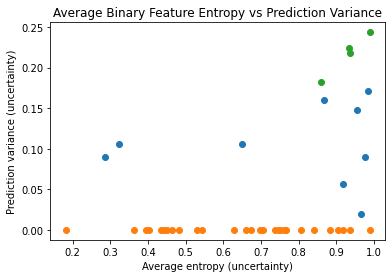

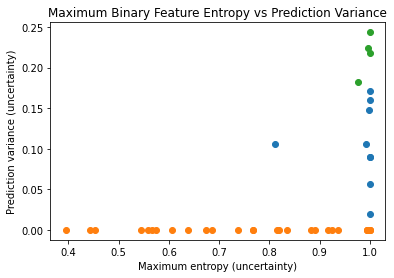

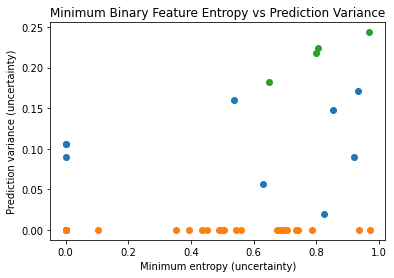

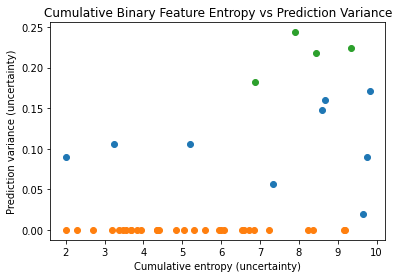

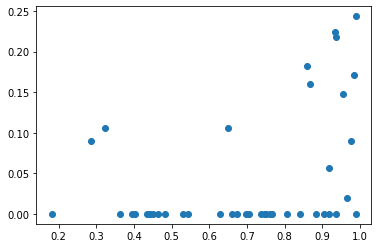

In [14]:
new_entropies = np.load('entropies_tmp.npy',allow_pickle=True).item()
new_pred_uncerts = list(np.load('pred_uncerts.npy',allow_pickle=True))
new_entropies_2 = np.load('entropies_tmp_2.npy',allow_pickle=True).item()
new_pred_uncerts_2 = list(np.load('pred_uncerts_2.npy',allow_pickle=True))


plt.figure()
plt.title('Average Binary Feature Entropy vs Prediction Variance')
plt.scatter(entropies['aeu'],pred_uncerts)
plt.scatter(new_entropies['aeu'],new_pred_uncerts)
plt.scatter(new_entropies_2['aeu'],new_pred_uncerts_2)
plt.xlabel('Average entropy (uncertainty)')
plt.ylabel('Prediction variance (uncertainty)')

plt.figure()
plt.title('Maximum Binary Feature Entropy vs Prediction Variance')
plt.scatter(entropies['meu'],pred_uncerts)
plt.scatter(new_entropies['meu'],new_pred_uncerts)
plt.scatter(new_entropies_2['meu'],new_pred_uncerts_2)
plt.xlabel('Maximum entropy (uncertainty)')
plt.ylabel('Prediction variance (uncertainty)')

plt.figure()
plt.title('Minimum Binary Feature Entropy vs Prediction Variance')
plt.scatter(entropies['mieu'],pred_uncerts)
plt.scatter(new_entropies['mieu'],new_pred_uncerts)
plt.scatter(new_entropies_2['mieu'],new_pred_uncerts_2)
plt.xlabel('Minimum entropy (uncertainty)')
plt.ylabel('Prediction variance (uncertainty)')

plt.figure()
plt.title('Cumulative Binary Feature Entropy vs Prediction Variance')
plt.scatter(entropies['ceu'],pred_uncerts)
plt.scatter(new_entropies['ceu'],new_pred_uncerts)
plt.scatter(new_entropies_2['ceu'],new_pred_uncerts_2)
plt.xlabel('Cumulative entropy (uncertainty)')
plt.ylabel('Prediction variance (uncertainty)')